In [1]:
import os
import subprocess
import torch
from torch.utils.data import DataLoader
from monai import transforms
from monai.data import Dataset
from monai.networks.nets.densenet import DenseNet201

In [2]:
template_path = '/home/jupyter-nafisha/Brain_age/templates/MNI152_T1_1mm_Brain.nii.gz'
model_path = "/home/jupyter-nafisha/Brain_age/synthstrip.pt"

In [3]:
# path = '/home/jupyter-nafisha/Brain_age/Abide_IXI_data/abide_10.nii.gz'

In [3]:
ants_bin = "/home/jupyter-nafisha/Brain_age/ants_2_6_3/ants-2.6.3/bin"
env = os.environ.copy()
env["PATH"] = ants_bin + ":" + env["PATH"]

def preprocessing(input_path, model_path, template_path):
    strip_out = os.path.join('/home/jupyter-nafisha/Brain_age/Temp_output', 'stripped.nii.gz')
    cmd = [
        "/home/jupyter-nafisha/.local/bin/nipreps-synthstrip",
        "-i", input_path,
        "-o", strip_out,
        "--model", model_path
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)
    # result = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    output_path = '/home/jupyter-nafisha/Brain_age/Temp_output/regis_' 
    reg_cmd = [
        f"{ants_bin}/antsRegistrationSyNQuick.sh",
        "-d", "3",
        "-f", template_path,
        "-m", strip_out,
        "-o", output_path
    ]
    subprocess.run(reg_cmd, env=env, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    return output_path + "Warped.nii.gz"

In [4]:
def get_inputs(inputs_path: str) -> list:
    
    def get_inputs_from_dir(inputs_path: str) -> list:
        is_nii = lambda f: f.endswith('.nii') or f.endswith('.nii.gz')
        files = os.listdir(inputs_path)
        input_paths = [ os.path.join(inputs_path, f) for f in files if is_nii(f) ]
        return input_paths

    def get_inputs_from_csv(inputs_path: str) -> list:
        with open(inputs_path, 'r') as f:
            return [ p.strip() for p in f.readlines() ]
        
    return get_inputs_from_dir(inputs_path) if os.path.isdir(inputs_path) \
        else get_inputs_from_csv(inputs_path)

transforms_fn = transforms.Compose([
    transforms.CopyItemsD(keys={'scan_path'}, names=['image']),
    transforms.LoadImageD(keys='image'),
    transforms.EnsureChannelFirstD(keys='image', channel_dim='no_channel'),
    transforms.SpacingD(keys='image', pixdim=1.4),
    transforms.ResizeWithPadOrCropD(keys='image', spatial_size=(130, 130, 130), mode='minimum'),
    transforms.ScaleIntensityD(keys='image', minv=0, maxv=1),
    transforms.Lambda(lambda d: d['image']),
])

In [5]:
# model = DenseNet201(3, 1, 1, dropout_prob=0)
# model.load_state_dict(torch.load(model_path, map_location=DEVICE))
# model = model.to(DEVICE).eval()

In [11]:
# input_folder = '/home/jupyter-nafisha/Brain_age/stripped'
# input_folder = '/home/jupyter-nafisha/Brain_age/Data'

# input_paths = get_inputs(input_folder)
# if len(input_paths) < 1: 
#     print('No images to process. Exiting.')
#     exit()

# preprocessed_paths = []
# for path in input_paths:
#     out_path= preprocessing(path, model_path, template_path)
#     preprocessed_paths.append(out_path)

# model_path = '/home/jupyter-nafisha/Brain_age/synthba-g.pth'
# DEVICE = 'cpu'
# batch_size = 1

In [16]:
# model

In [9]:
# # prepare the dataset
# data = [ { 'scan_path': p } for p in preprocessed_paths ]
# dataset = Dataset(data=data, transform=transforms_fn)    
# loader = DataLoader(dataset=dataset, batch_size=1)

In [9]:
# brain_age_list = []
# for i, images in enumerate(loader):
#     print(f'processing batch n.{i}')
#     with torch.no_grad():
#         brain_ages = model(images.to(DEVICE))
#         brain_age_list += list(brain_ages.view(-1).cpu().numpy() * 100)
#     break

In [5]:
densenet_path = '/home/jupyter-nafisha/Brain_age/synthba-g.pth'
DEVICE = 'cpu'
batch_size = 1

model = DenseNet201(3, 1, 1, dropout_prob=0)
model.load_state_dict(torch.load(densenet_path, map_location=DEVICE))
model = model.to(DEVICE).eval()

In [17]:
# IXI

# input_folder = '/home/common/IXI-T1'

# input_paths = get_inputs(input_folder)
# if len(input_paths) < 1: 
#     print('No images to process. Exiting.')
#     exit()

In [6]:
# Abide

import pandas as pd
df= pd.read_csv('ABIDE_I_relative_paths_with_age_sex.csv')
input_paths = list(df['relative_path'])[0:50]

In [16]:
# files

In [7]:
# input_folder = '/home/jupyter-nafisha/Brain_age/stripped'

# count=0

brain_age_list = []
full_list = []

for path in input_paths:
    out_path= preprocessing(path, model_path, template_path)

    dataset = Dataset(data= [{ 'scan_path': out_path }], transform=transforms_fn)  
    loader = DataLoader(dataset=dataset, batch_size=1)

    for i, images in enumerate(loader):
        print(f'processing batch n.{i}')
        with torch.no_grad():
            brain_ages = model(images.to(DEVICE))
            brain_age_list += list(brain_ages.view(-1).cpu().numpy() * 100)
            # full_list.append([path, brain_ages.view(-1).cpu().numpy() * 100])
        print(path, brain_ages.view(-1).cpu().numpy() * 100)
    
    # count+=1
    # if count==50:
    #     break

processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/CMU_50665/CMU_50665/anat/NIfTI/mprage.nii.gz [28.110949]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/Leuven_50707/Leuven_50707/anat/NIfTI/mprage.nii.gz [28.141264]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/OHSU_50160/OHSU_50160/anat/NIfTI/mprage.nii.gz [20.685213]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/Yale_50577/Yale_50577/anat/NIfTI/mprage.nii.gz [18.024315]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/SDSU_50198/SDSU_50198/anat/NIfTI/mprage.nii.gz [19.13241]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/NYU_51081/NYU_51081/anat/NIfTI/mprage.nii.gz [25.051373]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/Trinity_50263/Trinity_50263/anat/NIfTI/mprage.nii.gz [28.453386]
processing batch n.0
/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I/KKI_50790/KKI_50790/an

In [8]:
# brain_age_list
# full_list

In [9]:
csv_path = '/home/jupyter-nafisha/Brain_age/Temp_output/predictions_abide.csv'
with open(csv_path, 'w') as csv:
    csv.write("input_id,brainage\n")
    for scan_path, brain_age in zip(input_paths, brain_age_list):
        csv.write(f"{scan_path},{brain_age}\n")

In [8]:
brain_age_list

[np.float32(28.110949),
 np.float32(28.141264),
 np.float32(20.685213),
 np.float32(18.024315),
 np.float32(19.13241),
 np.float32(25.051373),
 np.float32(28.453386),
 np.float32(24.538568),
 np.float32(23.835234),
 np.float32(16.660236),
 np.float32(8.956393),
 np.float32(28.791508),
 np.float32(21.107277),
 np.float32(16.726),
 np.float32(29.765663),
 np.float32(30.624168),
 np.float32(25.872066),
 np.float32(21.894827),
 np.float32(24.948082),
 np.float32(23.09024),
 np.float32(25.34062),
 np.float32(28.31379),
 np.float32(28.407278),
 np.float32(30.804386),
 np.float32(27.620121),
 np.float32(15.516522),
 np.float32(18.71555),
 np.float32(18.85164),
 np.float32(16.534462),
 np.float32(15.936658),
 np.float32(16.42374),
 np.float32(18.690014),
 np.float32(26.52587),
 np.float32(11.977745),
 np.float32(26.862177),
 np.float32(24.905767),
 np.float32(15.37204),
 np.float32(12.980305),
 np.float32(17.199404),
 np.float32(18.005108),
 np.float32(31.283978),
 np.float32(11.268842),
 np.f

# MAE calculation- IXI

In [9]:
import pandas as pd

csv_path = '/home/jupyter-nafisha/Brain_age/Temp_output/prediction_IXI.csv'
pred= pd.read_csv(csv_path)

In [10]:
# pred['input_id'] = pred['input_id'].str.replace('/home/common/IXI-T1/', '', regex=False)
# pred

In [12]:
import numpy as np

mae = np.mean(np.abs(pred['actual_age'] - pred['predicted_age']))
print("MAE =", mae)

MAE = 11.860384801605687


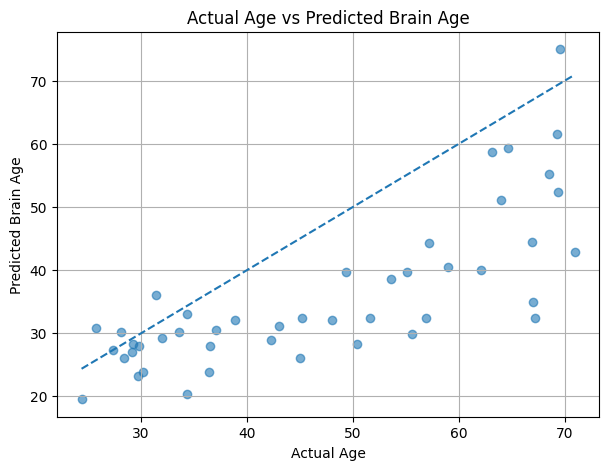

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(pred['actual_age'], pred['predicted_age'], alpha=0.6)

# Add diagonal y=x line
x = np.linspace(pred['actual_age'].min(), pred['actual_age'].max(), 100)
plt.plot(x, x, linestyle='--')

plt.xlabel('Actual Age')
plt.ylabel('Predicted Brain Age')
plt.title('Actual Age vs Predicted Brain Age')
plt.grid(True)
plt.show()


In [38]:
# making Zip of data for freesurfer

In [45]:
pwd

'/home/jupyter-nafisha/Brain_age'

In [46]:
import shutil
dest_dir = '/home/jupyter-nafisha/Brain_age/IXI_data'
for itr, row in final_df.iterrows():
    file_path= os.path.join('/home/common/IXI-T1', row['input_id'])
    shutil.copy(file_path, dest_dir)

In [47]:
import shutil

dest_dir = '/home/jupyter-nafisha/Brain_age/IXI_data'
zip_path = '/home/jupyter-nafisha/Brain_age/IXI_data'

shutil.make_archive(zip_path, 'zip', dest_dir)


'/home/jupyter-nafisha/Brain_age/IXI_data.zip'

# MAE calculation- ABIDE

In [10]:
import pandas as pd
df= pd.read_csv('ABIDE_I_relative_paths_with_age_sex.csv')
df

,Unnamed: 0,subject,relative_path,age_at_scan,sex
0,0,CMU_50665,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,33.00,1
1,1,Leuven_50707,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,22.00,1
2,2,OHSU_50160,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,11.45,1
3,3,Yale_50577,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,15.25,1
4,4,SDSU_50198,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,15.28,1
...,...,...,...,...,...
566,566,OHSU_50161,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,9.15,1
567,567,Caltech_51476,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,39.30,1
568,568,MaxMun_51363,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,32.00,1
569,569,MaxMun_51341,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,29.00,1


In [22]:
act_path = '/home/jupyter-nafisha/Brain_age/Temp_output/predictions_abide.csv'
act = pd.read_csv(act_path)
act

,input_id,brainage
0,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,28.110949
1,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,28.141264
2,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,20.685213
3,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,18.024315
4,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,19.132410
5,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,25.051373
6,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,28.453386
7,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,24.538568
8,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,23.835234
9,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,16.660236


In [28]:
merged = df.merge(
    act,
    left_on='relative_path',
    right_on='input_id',
    how='inner'
)
final= merged[['input_id', 'age_at_scan', 'brainage']]

In [31]:
# final 

In [30]:
final = final.rename(columns={'age_at_scan':'Actual_age', 'brainage':'Predicted_age'})
final

,input_id,Actual_age,Predicted_age
0,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,33.0000,28.110949
1,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,22.0000,28.141264
2,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,11.4500,20.685213
3,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,15.2500,18.024315
4,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,15.2800,19.132410
5,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,8.8200,25.051373
6,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,19.0800,28.453386
7,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,8.8300,24.538568
8,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,13.8000,23.835234
9,/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE...,15.7500,16.660236


In [68]:
ls

Abide_data/                              IXI_NEW_DF.csv
Abide_data.zip                           MNI152_T1_1mm_Brain.nii.gz
ABIDEII-BNI_1_29011.nii.gz               PreProcessing_IXI.ipynb
Abide.ipynb                              Register/
ABIDE_I_relative_paths_with_age_sex.csv  stripped/
Abide_IXI_data/                          synthba-g.pth
ants_2_6_3/                              synthstrip.pt
ants-2.6.3-ubuntu-24.04-X64-gcc.zip      templates/
inf.ipynb                                Temp_output/


In [33]:
import numpy as np

mae = np.mean(np.abs(final['Actual_age'] - final['Predicted_age']))
print("MAE =", mae)

MAE = 6.958175440887451


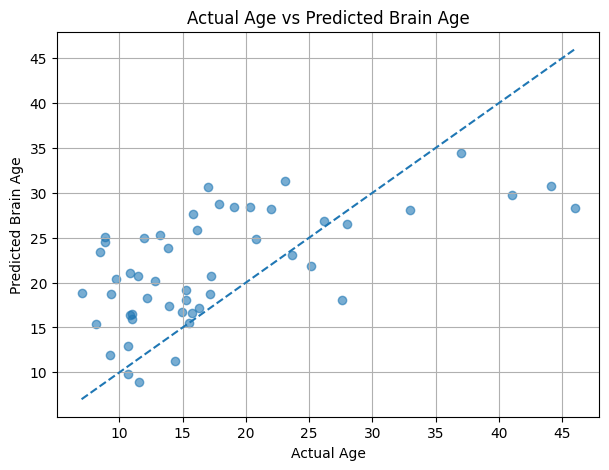

In [34]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(final['Actual_age'], final['Predicted_age'], alpha=0.6)

# Add diagonal y=x line
x = np.linspace(final['Actual_age'].min(), final['Actual_age'].max(), 100)
plt.plot(x, x, linestyle='--')

plt.xlabel('Actual Age')
plt.ylabel('Predicted Brain Age')
plt.title('Actual Age vs Predicted Brain Age')
plt.grid(True)
plt.show()


In [35]:
# Making data copy

In [42]:
abide_data= pd.read_csv('/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I_relative_paths_with_age_sex.csv')
abide_data

,subject,relative_path,age_at_scan,sex
0,CMU_50665,CMU_50665/CMU_50665/anat/NIfTI/mprage.nii.gz,33.00,1
1,Leuven_50707,Leuven_50707/Leuven_50707/anat/NIfTI/mprage.ni...,22.00,1
2,OHSU_50160,OHSU_50160/OHSU_50160/anat/NIfTI/mprage.nii.gz,11.45,1
3,Yale_50577,Yale_50577/Yale_50577/anat/NIfTI/mprage.nii.gz,15.25,1
4,SDSU_50198,SDSU_50198/SDSU_50198/anat/NIfTI/mprage.nii.gz,15.28,1
...,...,...,...,...
566,OHSU_50161,OHSU_50161/OHSU_50161/anat/NIfTI/mprage.nii.gz,9.15,1
567,Caltech_51476,Caltech_51476/Caltech_51476/anat/NIfTI/mprage....,39.30,1
568,MaxMun_51363,MaxMun_51363/MaxMun_51363/anat/NIfTI/mprage.ni...,32.00,1
569,MaxMun_51341,MaxMun_51341/MaxMun_51341/anat/NIfTI/mprage.ni...,29.00,1


In [59]:
import os
import shutil

src_root = '/home/common/ABIDE/ABIDE_DATA/ABIDE_DATA/ABIDE_I'
dest_root = '/home/jupyter-nafisha/Brain_age/Abide_data'

count = 0

for itr, row in abide_data.iterrows():
    rel_path = row['relative_path']  
    src_path = os.path.join(src_root, rel_path)
    dest_path = os.path.join(dest_root, rel_path)

    # copy only if source exists
    if os.path.exists(src_path):
        
        # now create folders
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        
        shutil.copy2(src_path, dest_path)
        count += 1
        # print("Copied:", count, src_path)
        if count == 50:
            break

    else:
        print("MISSING:", src_path)


In [62]:
zip_path= '/home/jupyter-nafisha/Brain_age/Abide_data'
shutil.make_archive(zip_path, 'zip', dest_root)

'/home/jupyter-nafisha/Brain_age/Abide_data.zip'

In [64]:
path = '/home/jupyter-nafisha/Brain_age/Temp_output/predictions_abide.csv'
data= pd.read_csv(path)

In [73]:
# data

# IXI- scanner-based MAE

In [76]:
import pandas as pd
csv_path= '/home/jupyter-nafisha/Brain_age/Temp_output/prediction_IXI.csv'

data= pd.read_csv(csv_path)

In [77]:
data

,input_id,actual_age,predicted_age
0,IXI585-Guys-1130-T1.nii.gz,28.120465,30.212820
1,IXI358-Guys-0919-T1.nii.gz,62.061602,40.060078
2,IXI296-HH-1970-T1.nii.gz,63.972621,51.119190
3,IXI306-IOP-0867-T1.nii.gz,30.182067,23.786682
4,IXI211-HH-1568-T1.nii.gz,55.118412,39.780205
5,IXI143-Guys-0785-T1.nii.gz,31.956194,29.320744
6,IXI227-Guys-0813-T1.nii.gz,67.055441,34.945030
7,IXI379-Guys-0943-T1.nii.gz,66.907598,44.474476
8,IXI145-Guys-0781-T1.nii.gz,49.385353,39.631454
9,IXI236-Guys-0817-T1.nii.gz,25.713895,30.783133


In [78]:
df_guys = data[data['input_id'].str.contains('guys', case=False, na=False)]
df_hh   = data[data['input_id'].str.contains('HH', case=False, na=False)]
df_iop  = data[data['input_id'].str.contains('IOP', case=False, na=False)]

In [82]:
len(df_guys), len(df_hh), len(df_iop)

(23, 15, 7)

In [89]:
df_guys
df_hh
df_iop

,input_id,actual_age,predicted_age
3,IXI306-IOP-0867-T1.nii.gz,30.182067,23.786682
13,IXI372-IOP-0971-T1.nii.gz,29.256674,28.237963
22,IXI395-IOP-0969-T1.nii.gz,45.032170,26.037741
24,IXI541-IOP-1146-T1.nii.gz,36.421629,23.925915
26,IXI434-IOP-1010-T1.nii.gz,67.241615,32.407127
36,IXI231-IOP-0866-T1.nii.gz,58.992471,40.559189
44,IXI378-IOP-0972-T1.nii.gz,38.839151,32.146187


In [85]:
mae_guys = np.mean(np.abs(df_guys['actual_age'] - df_guys['predicted_age']))
print("MAE (IOP):", mae_guys)

MAE (IOP): 13.096175548057278


In [86]:
mae_hh = np.mean(np.abs(df_hh['actual_age'] - df_hh['predicted_age']))
print("MAE (IOP):", mae_hh)

MAE (IOP): 8.909353664812176


In [84]:
import numpy as np

mae_iop = np.mean(np.abs(df_iop['actual_age'] - df_iop['predicted_age']))
print("MAE (IOP):", mae_iop)

MAE (IOP): 14.123567642107982
